In [1]:
from generate_study_montecarlo import generate_study
from pathlib import Path
from datetime import datetime


# What do you want to run?
save_parquet = True

start_type = "uniform"
duration_type = "parabolic"

num_randoms = 400
max_ltv_options = [0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
#utilization_param_options = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]
utilization_param_options = [0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3.0]

folder = f"studies/005-monte-carlo/start_{start_type}_duration_{duration_type}/"
Path(folder).mkdir(parents=True, exist_ok=True)

# Black Scholes

In [4]:
for max_ltv in max_ltv_options[::-1][:1]:
    for up in utilization_param_options[:1]:
        try:
            name = folder + f"montecarlo_BSM_ltv{str(max_ltv).replace('.', '_')}_up{str(up).replace('.', '_')}_x{num_randoms}_vf1.csv"
            if Path(name).exists():
                continue

            print(f"Starting with ltv {max_ltv} up {up}")
            study_results, timeseries = generate_study(
                ltv=max_ltv,
                fee_model="black_scholes",
                fee_model_update_params={"lookback_days": 365, "volatility_factor": 1.0},
                utilization_param_array = [up],
                loan_start_type_options = [start_type],
                loan_duration_type_options = [duration_type],
                num_randoms = num_randoms,
                volatility_factor=1.0,
                random_seed = 0,
            )
            study_results.to_csv(name)
            if save_parquet:
                timeseries.to_parquet(f"{name.replace('.csv', '_timeseries.parquet')}")
            print(f"Done with ltv {max_ltv} up {up}")
        except Exception as e:
            print(f"LTV {max_ltv} , UP {up} failed: {e}, {e.args}")

Starting with ltv 0.9 up 0.3
Running 400 simulations, approximate time 10.0 minues and 0.0 seconds.
Done with ltv 0.9 up 0.3


In [5]:
for max_ltv in max_ltv_options[::-1][:1]:
    for up in utilization_param_options[:1]:
        try:
            name = folder + f"montecarlo_BSM_ltv{str(max_ltv).replace('.', '_')}_up{str(up).replace('.', '_')}_x{num_randoms}_vf3.csv"
            if Path(name).exists():
                continue

            print(f"Starting with ltv {max_ltv} up {up}")
            study_results, timeseries = generate_study(
                ltv=max_ltv,
                fee_model="black_scholes",
                fee_model_update_params={"lookback_days": 365, "volatility_factor": 1.0},
                utilization_param_array = [up],
                loan_start_type_options = [start_type],
                loan_duration_type_options = [duration_type],
                num_randoms = num_randoms,
                volatility_factor=3.0,
                random_seed = 0,
            )
            study_results.to_csv(name)
            if save_parquet:
                timeseries.to_parquet(f"{name.replace('.csv', '_timeseries.parquet')}")
            print(f"Done with ltv {max_ltv} up {up}")
        except Exception as e:
            print(f"LTV {max_ltv} , UP {up} failed: {e}, {e.args}")

Starting with ltv 0.9 up 0.3
Running 400 simulations, approximate time 10.0 minues and 0.0 seconds.
Done with ltv 0.9 up 0.3


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ts_vf1 = pd.read_parquet("studies/005-monte-carlo/start_uniform_duration_parabolic/montecarlo_BSM_ltv0_9_up0_3_x400_vf1_timeseries.parquet")
ts_vf3 = pd.read_parquet("studies/005-monte-carlo/start_uniform_duration_parabolic/montecarlo_BSM_ltv0_9_up0_3_x400_vf3_timeseries.parquet")

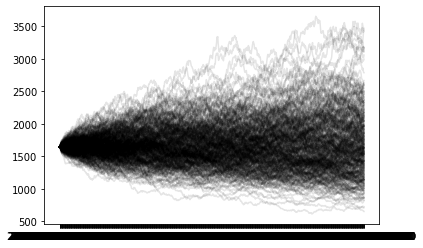

In [10]:
for seed in ts_vf1["seed"].unique():
    ts_vf1_seed = ts_vf1[ts_vf1["seed"] == seed]
    plt.plot(ts_vf1_seed["timestamp"], ts_vf1_seed["collateral_price"], alpha=0.1, color="black")

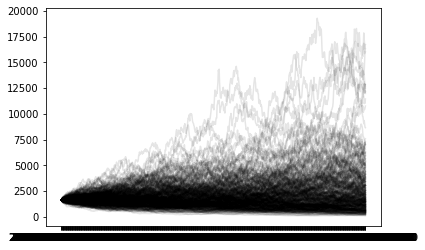

In [13]:
for seed in ts_vf3["seed"].unique():
    ts_vf3_seed = ts_vf3[ts_vf3["seed"] == seed]
    plt.plot(ts_vf3_seed["timestamp"], ts_vf3_seed["collateral_price"], alpha=0.1, color="black")

In [15]:
log_returns_1 = []
log_returns_3 = []
first_price = ts_vf1["collateral_price"].iloc[0]
for seed in ts_vf1["seed"].unique():
    ts_vf1_seed = ts_vf1[ts_vf1["seed"] == seed]
    ts_vf3_seed = ts_vf3[ts_vf3["seed"] == seed]
    last_collat_price_1 = ts_vf1_seed["collateral_price"].iloc[-1]
    last_collat_price_3 = ts_vf3_seed["collateral_price"].iloc[-1]
    log_returns_1.append(np.log(last_collat_price_1/first_price))
    log_returns_3.append(np.log(last_collat_price_3/first_price))

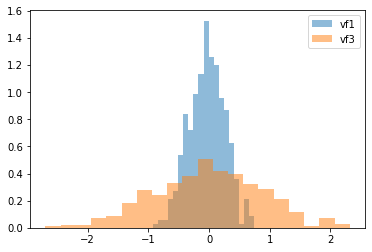

In [20]:
plt.hist(log_returns_1, bins=20, alpha=0.5, label="vf1", density=True)
plt.hist(log_returns_3, bins=20, alpha=0.5, label="vf3", density=True)
plt.legend()

Text(0, 0.5, 'RMSE (% of error from expected VaR)')

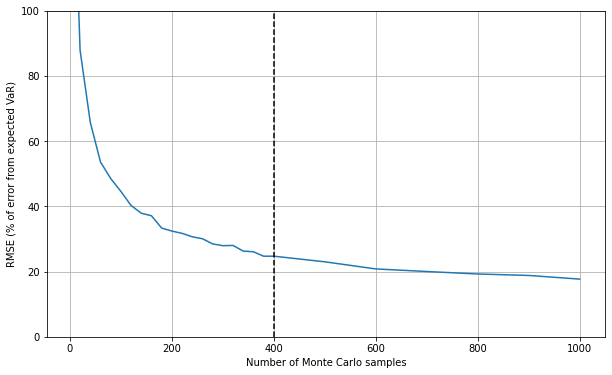

In [50]:
# bootstrapping
df = pd.read_csv("studies/005-monte-carlo/start_uniform_duration_parabolic/montecarlo_BSM_ltv0_9_up0_3_x400_vf1.csv")
pnls = df["pnl_ratio"]
actual_var = -np.percentile(pnls, 5)

def bootstrap(pnl, samples, num_bootstraps, percentile):
    vars = []
    for i in range(num_bootstraps):
        sample = np.random.choice(pnl, samples, replace=True)
        vars.append(np.percentile(sample, percentile))
    return np.array(vars)

num_samples_to_try = [5, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 500, 600, 700, 800, 900, 1000]
errors = []
for samples in num_samples_to_try:
    vars = -bootstrap(pnls, samples, num_bootstraps=1000, percentile=5)
    mean_var = np.mean(vars)
    rmse = np.sqrt(np.mean(((vars - mean_var)/mean_var)**2))

    errors.append(rmse)
errors = np.array(errors)

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(num_samples_to_try, errors*100)
plt.axvline(x=400, color="black", linestyle="--")

plt.ylim(0, 100)
plt.grid(True)
plt.xlabel("Number of Monte Carlo samples")
plt.ylabel(f"RMSE (% of error from expected VaR)")

## Combined BSM and traditional

In [ ]:
for max_ltv in max_ltv_options[::-1]:
    for up in utilization_param_options:
        try:
            name = folder + f"montecarlo_combined_ltv{str(max_ltv).replace('.', '_')}_up{str(up).replace('.', '_')}_x{num_randoms}.csv"
            if Path(name).exists():
                continue

            print(f"Starting with ltv {max_ltv} up {up}")
            study_results, timeseries = generate_study(
                ltv=max_ltv,
                fee_model="combined_bsm_traditional",
                fee_model_update_params={
                    "lookback_days": 365,
                    "volatility_factor": 1.0,
                    "optimal_utilization": 0.8,
                    "base_rate": 0.01,
                    "rate_slope_1": 0.005,
                    "rate_slope_2": 0.75,
                },                
                utilization_param_array = [up],
                loan_start_type_options = [start_type],
                loan_duration_type_options = [duration_type],
                num_randoms = num_randoms,
                random_seed = 0,
            )
            study_results.to_csv(name)
            if save_parquet:
                timeseries.to_parquet(f"{name.replace('.csv', '_timeseries.parquet')}")
            print(f"Done with ltv {max_ltv} up {up}")
        except Exception as e:
            print(f"LTV {max_ltv} , UP {up} failed: {e}, {e.args}")

## Sum BSM and traditional

In [ ]:
for max_ltv in max_ltv_options[::-1]:
    for up in utilization_param_options:
        try:
            name = folder + f"montecarlo_sum_ltv{str(max_ltv).replace('.', '_')}_up{str(up).replace('.', '_')}_x{num_randoms}.csv"
            if Path(name).exists():
                continue

            print(f"Starting with ltv {max_ltv} up {up}")
            study_results, timeseries = generate_study(
                ltv=max_ltv,
                fee_model="sum_bsm_traditional",
                fee_model_update_params={
                    "lookback_days": 365,
                    "volatility_factor": 1.0,
                    "optimal_utilization": 0.8,
                    "base_rate": 0.01,
                    "rate_slope_1": 0.005,
                    "rate_slope_2": 0.75,
                },                
                utilization_param_array = [up],
                loan_start_type_options = [start_type],
                loan_duration_type_options = [duration_type],
                num_randoms = num_randoms,
                random_seed = 0,
            )
            study_results.to_csv(name)
            if save_parquet:
                timeseries.to_parquet(f"{name.replace('.csv', '_timeseries.parquet')}")
            print(f"Done with ltv {max_ltv} up {up}")
        except Exception as e:
            print(f"LTV {max_ltv} , UP {up} failed: {e}, {e.args}")

## Traditional

In [ ]:
for max_ltv in max_ltv_options[::-1]:
    for up in utilization_param_options:
        try:
            name = folder + f"montecarlo_aave_ltv{str(max_ltv).replace('.', '_')}_up{str(up).replace('.', '_')}_x{num_randoms}.csv"
            if Path(name).exists():
                continue

            print(f"Starting with ltv {max_ltv} up {up}")
            study_results, timeseries = generate_study(
                ltv=max_ltv,
                fee_model="traditional",
                fee_model_update_params={
                    "optimal_utilization": 0.8,
                    "base_rate": 0.01,
                    "rate_slope_1": 0.005,
                    "rate_slope_2": 0.75,
                },                
                utilization_param_array = [up],
                loan_start_type_options = [start_type],
                loan_duration_type_options = [duration_type],
                num_randoms = num_randoms,
                random_seed = 0,
            )
            study_results.to_csv(name)
            if save_parquet:
                timeseries.to_parquet(f"{name.replace('.csv', '_timeseries.parquet')}")
            print(f"Done with ltv {max_ltv} up {up}")
        except Exception as e:
            print(f"LTV {max_ltv} , UP {up} failed: {e}, {e.args}")